In [1]:
import os

import pandas as pd

import torch
import torch.nn as nn
from torch import Tensor

# 1. Data

## 1.1. Upload

In [2]:
DATASET_ROOT_P = os.path.join('./datasets')

TRAIN_P = os.path.join(DATASET_ROOT_P, 'translation_tatoeba_train.csv')
TEST_P = os.path.join(DATASET_ROOT_P, 'translation_tatoeba_test.csv')

In [3]:
train_df = pd.read_csv(TRAIN_P)
test_df = pd.read_csv(TEST_P)

print(f'train: {train_df.shape[0]}')
print(f'test: {test_df.shape[0]}')

train: 149904
test: 16657


In [4]:
train_df.head(3)

,Eng,Fre
0,I made a lot of mistakes.,J'ai commis de nombreuses erreurs.
1,I think I've already given you enough money.,Je pense que je t'ai déjà donné suffisamment d...
2,No one knows why Tom wanted to do that.,Personne ne sait pourquoi Tom voulait faire ça.


## 1.2. Tokenization

In [5]:
from transformers import BertTokenizerFast

In [6]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-multilingual-uncased")

In [7]:
_t_text = train_df['Fre'].iloc[6]
_t_text

'Avez-vous quelques minutes ?'

In [8]:
inputs = tokenizer(_t_text, return_tensors="pt")

In [9]:
inputs

{'input_ids': tensor([[  101, 26446, 10311,   118, 22812, 14994, 15021,   136,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [10]:
inputs.tokens()

['[CLS]', 'ave', '##z', '-', 'vous', 'quelques', 'minutes', '?', '[SEP]']

In [11]:
tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=True)

'avez - vous quelques minutes?'

In [12]:
tokenizer.vocab_size

105879

# 2. Recursive Attention

In [13]:
EMBEDDING_DIM = 384
embedding = torch.nn.Embedding(num_embeddings=tokenizer.vocab_size, embedding_dim=EMBEDDING_DIM)

In [14]:
print(len(inputs["input_ids"][0]))
print(embedding(inputs["input_ids"][0]).shape)

9
torch.Size([9, 384])


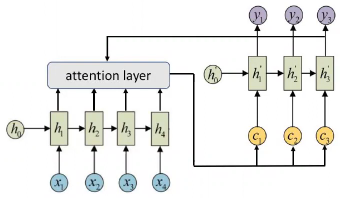

Обозначения:

- $a(h,h')$ - функция сходства состояний входа $h$ и выхода $h'$
- $\alpha_{ti}$ - важность входа $i$ для выхода $t$ (attention score)
- $c_t$ - вектор входного контекста для выхода $t$ (context vector)

Устройство Encoder-Decoder с Attention Layer:

$$
h_i = f_{in}(x_i, h_{i-1})
$$

$$
\alpha_{ti} = norm_i a(h_i, h_{t-1}'), \quad \forall i
$$

$$
c_t = \sum_{i}{
    \alpha_{ti}h_i
}
$$

$$
h_t' = f_{out}(h'_{t-1}, y_{t-1}, c_t)
$$

$$
y_t = f_y(h'_{t}, y_{t-1}, c_t)
$$

Где

$$
norm_i(p_i) = \frac{p_i}{\sum_k{p_k}}
$$

Пусть

- $h_i = f_{in}(x_i, h_{i-1}) = \sigma_h(Ux_t + Wh_{t-1})$
- $h_t' = f_{out}(h'_{t-1}, y_{t-1}, c_t) = \tanh{(W_{out}[h'_{t-1}, y_{t-1}, c_t])}$
- $y_t = f_y(h'_{t}, y_{t-1}, c_t) = \tanh{(W_{y}[h'_{t}, y_{t-1}, c_t])}$
- $a(h,h') = h^Th'$ - скалярное произведение

## 2.1. Model

In [15]:
def norm_vect(x: Tensor) -> Tensor:
    return x / x.sum()

In [16]:
class EncoderRNN(nn.Module):
    def __init__(self, embedding_size: int, hidden_size: int = 512):
        super(EncoderRNN, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        # hidden states
        self.enc_hidden = torch.randn(self.hidden_size, requires_grad=True)
        # projections
        self.U = torch.randn((self.embedding_size, self.hidden_size), requires_grad=True)
        self.W = torch.randn((self.hidden_size, self.hidden_size), requires_grad=True)

    def f_in(self, x_vect: Tensor, h_enc_vect: Tensor) -> Tensor:
        return torch.nn.functional.sigmoid((x_vect @ self.U) + (self.W @ h_enc_vect))

    def forward(self, x_seq: Tensor) -> Tensor:
        h = [self.enc_hidden]
        for xi in x_seq:
            hi = self.f_in(xi, h[-1])
            h.append(hi)
        return torch.vstack(h[1:])

In [17]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size: int = 512):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        # hidden states
        self.dec_hidden = torch.randn(self.hidden_size, requires_grad=True)
        self.y_hidden = torch.randn(self.hidden_size, requires_grad=True)
        # projections
        self.W_out = torch.randn((3*self.hidden_size, self.hidden_size), requires_grad=True)
        self.W_y = torch.randn((3*self.hidden_size, self.hidden_size), requires_grad=True)
    
    def f_out(self, h_prev: Tensor, y_prev: Tensor, ct: Tensor) -> Tensor:
        concat = torch.cat([h_prev, y_prev, ct], dim=-1)
        return torch.tanh(concat @ self.W_out)
    
    def f_y(self, ht: Tensor, y_prev: Tensor, ct: Tensor) -> Tensor:
        concat = torch.cat([ht, y_prev, ct], dim=-1)
        return torch.tanh(concat @ self.W_y)
    
    def forward(self, encoder_out: Tensor) -> list[Tensor]:
        h_dec = [self.dec_hidden]
        y = [self.y_hidden]
        for out_idx in range(10):  # (yt)
            att = norm_vect(encoder_out @ h_dec[-1])
            ct = (att.view(-1, 1) * encoder_out).sum(axis=0)
            ht = self.f_out(h_dec[-1], y[-1], ct)
            h_dec.append(ht)
            yt = self.f_y(h_dec[-1], y[-1], ct)
            y.append(yt)
        y = torch.stack(y[1:])
        return y

In [18]:
class RecursiveAttention(nn.Module):
    def __init__(self, embedding_size: int, hidden_size: int = 512):
        super(RecursiveAttention, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        # model
        self.encoder = EncoderRNN(self.embedding_size, self.hidden_size)
        self.decoder = DecoderRNN(self.hidden_size)

    def forward(self, x_seq: Tensor) -> Tensor:
        encoded = self.encoder(x_seq)
        decoded = self.decoder(encoded)
        return decoded

In [19]:
BS = 8
_t_text_batch = train_df['Eng'].iloc[:BS].tolist()
_t_inputs = tokenizer(_t_text_batch, return_tensors="pt", padding=True)

In [20]:
tokenizer.decode(_t_inputs['input_ids'][0])

'[CLS] i made a lot of mistakes. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [21]:
_t_inputs['input_ids'][0]

tensor([  101,   151, 11050,   143, 15632, 10108, 83967, 10107,   119,   102,
            0,     0,     0,     0,     0,     0,     0])

In [22]:
t_batch = embedding(_t_inputs['input_ids'])
t_batch.shape

torch.Size([8, 17, 384])

In [23]:
EMBEDDING_DIM = 384
HIDDEN_SIZE = 512

rec_att = RecursiveAttention(EMBEDDING_DIM, HIDDEN_SIZE)

In [24]:
t_batch[0].shape

torch.Size([17, 384])

In [25]:
rec_att(t_batch[0]).shape

torch.Size([10, 512])